<a href="https://colab.research.google.com/github/JoeL-8883/Fencing-Score-Predictor/blob/main/predict_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from bs4 import BeautifulSoup
import requests
import os
import gdown
import kagglehub

In [3]:
path = kagglehub.dataset_download("foillee/fencing-points")
csv_path = os.path.join(path, 'data.csv')
df = pd.read_csv(csv_path)
df = df.sort_values(by='date')
df['date'] = pd.to_datetime(df['date'])
df.head()


,fie_ID,fencer_name,age,dob,nationality,rank,host_city,event_type,points_earned,date
5279,17148,ROWLES Thomas,17,1990-05-30,GBR,504,Londres,Satellite,0.0,2007-10-21
4878,14529,REMIJN Martin,18,1989-07-25,NED,251,Londres,Satellite,0.0,2007-10-21
4873,16321,STIJLAART Mats,17,1990-10-08,NED,250,Londres,Satellite,0.0,2007-10-21
4864,17823,AVOLA Giorgio,18,1989-05-08,ITA,247,Londres,Satellite,2.0,2007-10-21
4858,3247,KENBER Jamie,20,1986-11-14,GBR,245,Londres,Satellite,3.0,2007-10-21


In [4]:
'''Remove satellite events - these give very few points so even winning a satellite implies that a fencer performed poorly'''
'''We can assume that top fencers do not attend these events - they are the subject of this project for now'''
'''At some point I will have to devise a better metric than points'''
df = df[df['event_type'] != 'Satellite']

'''Delete data for fencers who do not compete regularly'''
# NOTE - the threshold must be equal to sequence_length / train_split
threshold = 20 # the number of non-satellite events each fencer must have attended to be considered
fencer_counts = df['fencer_name'].value_counts()
fencers_to_delete = fencer_counts[fencer_counts < 20].index
print(f'Deleting {len(fencers_to_delete)} fencers')
df = df[~df['fencer_name'].isin(fencers_to_delete)]

Deleting 1735 fencers


Different levels of competitions multiply points by different factors, for instance, in the Olympics you can see the spike in points in Cheung Ka Long's two Olympic golds. So we use and predict rolling averages

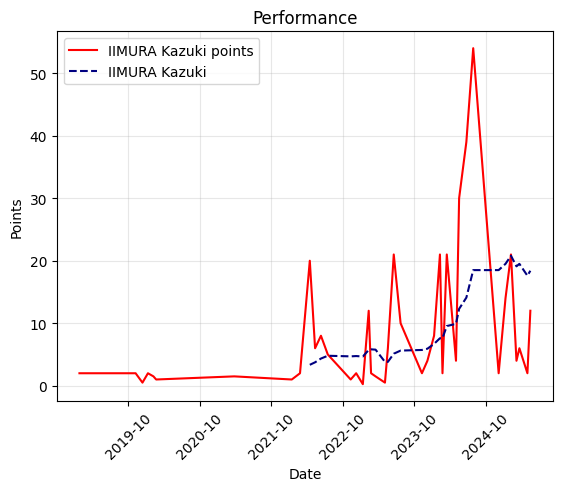

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fencer_name = 'IIMURA Kazuki'
df_fencer = df[df['fencer_name'] == fencer_name]
plt.title('Performance')
plt.xlabel('Date')
plt.ylabel('Points')

# Compute rolling averages
window = 10
rolling_avg = df_fencer['points_earned'].rolling(window=window).mean()
plt.plot(df_fencer['date'], df_fencer['points_earned'], label=fencer_name + ' points', color='red')
plt.plot(df_fencer['date'], rolling_avg, label=fencer_name, color='navy', linestyle='--')


plt.grid(True, alpha=0.3)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.show()


In [6]:
window_size = 10
# Compute rolling averages
df['rolling_avg_points'] = df.groupby('fencer_name')['points_earned'].transform(lambda x: x.rolling(window=window_size).mean())

# Fill NaN values
df['rolling_avg_points'] = df['rolling_avg_points'].fillna(method='bfill') # Fill initial NaNs with the first valid value
df['rolling_avg_points'] = df['rolling_avg_points'].fillna(0) # Fill any remaining NaNs with 0 if necessary


<ipython-input-6-b4d1556c2e32>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['rolling_avg_points'] = df['rolling_avg_points'].fillna(method='bfill') # Fill initial NaNs with the first valid value


In [7]:
points_mean = df['points_earned'].mean()
points_std = df['points_earned'].std()
df['points_normalised'] = (df['points_earned'] - points_mean) / points_std

rolling_mean = df['rolling_avg_points'].mean()
rolling_std = df['rolling_avg_points'].std()
df['rolling_avg_points_normalised'] = (df['rolling_avg_points'] - rolling_mean) / rolling_std

### Predictive Model

Dataset

Points alone is not good enough data in predicting a fencer's performance in the future, we need to include features such as their rank at the time, their age, etc.

In [8]:
'''One-hot encoding of fencer's nationality'''
one_hot_nationality = pd.get_dummies(df['nationality'], prefix='nationality')
df = pd.concat([df, one_hot_nationality], axis=1)

~~Number of competitions -- we would expect that fencers peak after a number of competitions, however their performance will also degrade as they get older and their physique wears down.~~

We can't use this as this counts instances of competitions, not the nth competition a fencer actually competed in!

In [9]:
#df['competition_count'] = df.groupby('fencer_name').cumcount() + 1

In [10]:
class FencerSequenceDataset(Dataset):
  def __init__(self, df, sequence_length=11):
    self.sequences = []
    self.targets = []
    self.sequence_length = sequence_length

    for fencer_name, fencer_df in df.items():
      # Concatenate features with one-hot encoding of nationalities
      ranking_data = fencer_df[['points_normalised', 'rolling_avg_points_normalised', 'rank', 'age']].values
      nationality_columns = [col for col in fencer_df.columns if col.startswith('nationality_')]
      features = np.concatenate((ranking_data, fencer_df[nationality_columns].values), axis=1)

      # Create sliding windows
      for i in range(len(features) - sequence_length):
        point = features[i:i+sequence_length]
        target = features[i+sequence_length, 1] # only predict rolling_avg_points_normalised

        self.sequences.append(torch.tensor(point, dtype=torch.float32)) # convert to tensors so they can be stacked
        self.targets.append(torch.tensor(target, dtype=torch.float32))

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, idx):
    return self.sequences[idx], self.targets[idx]


In [11]:
''' Split the data for each fencer'''
data_size = len(df)
train_split = 0.6
val_split = 0.2
test_split = 0.2

fencer_train_data = {}
fencer_val_data = {}
fencer_test_data = {}

fencers_grouped = df.groupby('fencer_name') # We can naively assume that each fencer has a different name

for fencer_name, fencer_df in fencers_grouped:
  fencer_df = fencer_df.sort_values(by='date')

  total_size = len(fencer_df)
  train_size = int(total_size * train_split)
  val_size = int(total_size * val_split)
  test_size = total_size - train_size - val_size

  # Split Data
  fencer_train_data[fencer_name] = fencer_df[:train_size]
  fencer_val_data[fencer_name] = fencer_df[train_size:train_size + val_size]
  fencer_test_data[fencer_name] = fencer_df[train_size + val_size:]

In [12]:
training_data = FencerSequenceDataset(fencer_train_data)
val_data = FencerSequenceDataset(fencer_val_data)
test_data = FencerSequenceDataset(fencer_test_data)

batch_size=32
train_dataloader = DataLoader(training_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Setup model

In [13]:
'''Start with a basic RNN'''
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.25):
      super(RNN, self).__init__()
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.output_size = output_size
      self.dropout = nn.Dropout(dropout)

      self.W_ih = nn.Linear(input_size, hidden_size, bias=True) # input to hidden
      self.W_hh = nn.Linear(hidden_size, hidden_size, bias=True) # hidden weights
      self.W_ho = nn.Linear(hidden_size, output_size, bias=True) # hidden to output

    def forward(self, input, h_0=None):
      if h_0 is None:
        h_0 = torch.zeros(self.hidden_size, device=device)

      input = self.dropout(input)
      h_t = torch.tanh(self.W_ih(input) + self.W_hh(h_0))
      h_t = self.dropout(h_t)
      ouput = self.W_ho(h_t)

      return ouput, h_t

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [15]:
'''Valdiation'''
def evaluate_model(model, dataloader):
  model.eval()
  total_val_loss = 0

  with torch.no_grad():
    for sequences, targets in val_dataloader:
      sequences = sequences.to(device)
      targets = targets.to(device)
      batch_loss = 0

      for i in range(sequences.size(0)):
        sequence = sequences[i]
        target = targets[i]

        hidden_state = torch.zeros(model.hidden_size, device=device)
        output = None

        for t in range(sequence.size(0)):
          output, hidden_state = model(sequence[t].unsqueeze(0), hidden_state)

          # Calculate loss for each prediction in the sequence
          loss = criterion(output, target.unsqueeze(0))
          batch_loss += loss

      average_batch_loss = batch_loss / sequences.size(0)
      total_val_loss += average_batch_loss.item()

  average_val_loss = total_val_loss / len(val_dataloader)
  print(f'Average Validation Loss: {average_val_loss:.4f}')
  return average_val_loss

In [16]:
input_size = 4 # number of features
nationality_count = len([col for col in df.columns if col.startswith('nationality_')])
input_size += nationality_count

hidden_size = 100 # A larger hidden_size causes the model to overfit
output_size = 1 # i.e. predicting points earned from a competition

dropout = 0.3
best_val_loss = float('inf')
patience = 5
counter = 0
best_model = None


model = RNN(input_size, hidden_size, output_size, dropout)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)

In [17]:
train = False

if train:
  epochs = 20

  for epoch in range(epochs):
    total_train_loss = 0
    num_batches = 0

    model.train()

    for sequences, targets in train_dataloader: # iterate through each batch
      optimizer.zero_grad()
      batch_loss = 0

      sequences = sequences.to(device) # shape: (batch_size, sequence_length, input_size)
      targets = targets.to(device) # shape: batch_size

      # Iterate through each sequence in the batch
      for i in range(sequences.size(0)):
        sequence = sequences[i]
        target = targets[i]

        hidden_state = torch.zeros(model.hidden_size, device=device) # reset the hidden state for each sequence
        output = None

        # Compute loss for a single sequence
        for t in range(sequence.size(0)):
          output, hidden_state = model(sequence[t].unsqueeze(0), hidden_state)

          loss = criterion(output, target.unsqueeze(0)) # loss for a single sequence
          batch_loss += loss # losses for all sequences in a batch

      # Compute losses after each sequence
      average_batch_loss = batch_loss / sequences.size(0)
      average_batch_loss.backward()
      optimizer.step()

      total_train_loss += average_batch_loss.item()

    average_train_loss = total_train_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{epochs}], Average Training Loss: {average_train_loss:.4f}')

    # Validation loss
    val_loss = evaluate_model(model, val_dataloader)

    if val_loss < best_val_loss:
      counter = 0
      best_val_loss = val_loss
      best_model = model.state_dict()
    else:
      counter += 1
      if counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break
  torch.save(best_model, 'model.pth')

In [18]:
model_path = '/content/model.pth'
model = RNN(input_size, hidden_size, output_size)

if str(device) == 'cpu':
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
else:
  model = model.to(device)
  model.load_state_dict(torch.load(model_path))


In [19]:
'''Testing'''
model.eval()
total_test_loss = 0
num_batches = 0

with torch.no_grad():
  for sequences, targets in test_dataloader:
    sequences = sequences.to(device)
    targets = targets.to(device)
    batch_loss = 0
    for i in range(sequences.size(0)):
      hidden_state = torch.zeros(model.hidden_size, device=device)
      sequence = sequences[i]
      target = targets[i]
      output = None

      for t in range(len(sequence)):
        output, hidden_state = model(sequence[t].unsqueeze(0), hidden_state)

        loss = criterion(output, target.unsqueeze(0))
        batch_loss += loss.item()

    average_batch_loss = batch_loss / sequences.size(0)
    total_test_loss += average_batch_loss

average_test_loss = total_test_loss / len(test_dataloader)
print(f'Average Test Loss: {average_test_loss:.4f}')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 3.0686


In [20]:
# Get the next competition date based on the date of the next event from the season before
# Fencing competitions are held within days of each other in previous seasons so this assumption is valid
def get_next_comp_date(pred_df, nationality,date_df=None):
  '''
    Predict the next date of the fencing competiton based on when competitions were held the previous season

    Args:
      pred_df: the dataframe of predictions
      nationality: the nationality of the fencer to predict for
      date_df: a dataframe of the dates of all competitions past and predicted

    Returns:
      pred_date: predicted date of the next competition
      date_df: the dataframe of all dates of competitions
  '''

  if date_df is None:
    nationality_df = df[df['nationality'] == nationality]
    date_df = nationality_df.drop_duplicates(subset=['date'])
  last_comp_date = pred_df.iloc[-1]['date']
  prev_year = last_comp_date - pd.Timedelta(days=365)
  prev_comp_dates = date_df[(date_df['date'] >= prev_year) & (date_df['date'] < last_comp_date)]
  prev_comp_dates = prev_comp_dates.sort_values(by='date')

  if prev_comp_dates.empty:
    raise Exception(f'No previous competitions found, exception has not yet been implemented.')
  else:
    # Search for the most recent competition then the compeition that comes after
    # Get the second entry as the first entry is just the last competiton the fencer competed at
    pred_date_df = prev_comp_dates.iloc[[1]].copy()
    pred_date_df['date'] = pred_date_df['date'] + pd.Timedelta(days=365)
    date_df = pd.concat([date_df, pred_date_df], ignore_index=True)
    pred_date = pred_date_df.iloc[0]['date']
    return pred_date, date_df

In [21]:
def fencer_forecast_full_history(model, fencer_df, num_predictions):
  '''
  Perform autoregressive forecasting for a given fencer

  Args:
    model: trained RNN
    fencer_df: DataFrame containing all competition data for a particular fencer
    num_predictions: number of future predictions ot predict

  Returns:
    A DataFrame of future predicted rolling averages
  '''

  model.eval()
  fencer_copy_df = fencer_df.copy().sort_values(by='date')
  features = ['points_normalised', 'rolling_avg_points_normalised', 'age', 'rank']
  nationality_cols = [col for col in fencer_df.columns if col.startswith('nationality_')]
  all_features = features + nationality_cols
  history = fencer_copy_df[all_features].values.astype(np.float32)
  history_tensor = torch.tensor(history, dtype=torch.float32, device=device)

  # Initialise prediction df
  last_comp_row = fencer_copy_df.iloc[-1]
  last_comp_data = {
      'fencer_name': last_comp_row['fencer_name'],
      'age': last_comp_row['age'],
      'points_earned': last_comp_row['points_earned'],
      'date': last_comp_row['date']
  }
  date_df = None

  pred_df_headers = ['fencer_name', 'age', 'points_earned', 'date']
  pred_df = pd.DataFrame(data=last_comp_data, columns=pred_df_headers, index=[0])

  # Process entire history
  with torch.no_grad():
    hidden_state = None
    output = None
    for t in range(history_tensor.size(0)):
      output, hidden_state = model(history_tensor[t].unsqueeze(0), hidden_state)

  '''
  Autoregressive prediction
    also compose prediction df using predicted values and fencer features
  '''
  nationality_features = fencer_df.iloc[-1][nationality_cols].values.tolist()
  rank = fencer_df.iloc[-1]['rank']

  # Unsqueeze creates a new dimension to create mini-batch of size 1
  last_step = history_tensor[-1, :].unsqueeze(0)

  for i in range(num_predictions):
    with torch.no_grad():
      output, hidden_state = model(last_step, hidden_state)
      predicted_rolling_avg_normalised = output.item()

      # We must assume that points is similar to the rolling average (as its difficult to compute the points earned)
      # !!! Could we determine what type of event would be next then determine multipliers from there?
      predicted_points_normalised = predicted_rolling_avg_normalised

      # Predict the date of the next competition
      last_comp_date = pred_df.iloc[-1]['date']
      nationality = fencer_df.iloc[-1]['nationality']
      next_comp_date_pred, date_df = get_next_comp_date(pred_df, nationality, date_df)
      dob = fencer_df.iloc[-1]['dob']
      next_age = int((next_comp_date_pred - pd.to_datetime(dob)).days / 365.25)

      new_features = [
          predicted_points_normalised,
          predicted_rolling_avg_normalised,
          next_age,
          rank
      ]
      new_features.extend(nationality_features)

      new_features_array = np.array(new_features, dtype=np.float32)
      last_step = torch.tensor(new_features_array, device=device) # New features becomes the input for the next iteration

      # Add prediction to df
      predicted_rolling_avg = predicted_rolling_avg_normalised * rolling_std + rolling_mean

      new_row = {col: None for col in pred_df_headers}
      new_row.update({
          'fencer_name': fencer_df.iloc[-1]['fencer_name'],
          'age': next_age,
          'points_earned': predicted_rolling_avg,
          'date': pd.to_datetime(next_comp_date_pred)
      })
      pred_df = pd.concat([pred_df, pd.DataFrame([new_row])], ignore_index=True)

  return pred_df.sort_values(by='date')

In [22]:
fencer_name = 'IIMURA Kazuki'
num_predictions = 20


fencer_df = df[df['fencer_name'] == fencer_name]
if fencer_df.empty:
  print(f'No data found for {fencer_name}')
  exit()

predictions = fencer_forecast_full_history(model, fencer_df, num_predictions)
print(predictions)

No data found for PENMANN Callum


IndexError: single positional indexer is out-of-bounds